# Spatiotemporal Trends in Urbanization: Cameroon
*Using yearly estimates (2000-2015) of population, built-area, and economic indicators to track city-by-city growth and change over time.*

---

### Research questions 

#### 1. How has the size of Settlement X changed over time? 

- Population size 

- Geographical extents 

- Population density 

#### 2. In what year did Settlement X become a new urban class?  

- From semi-dense to high-density city 

- Small settlement area to built-up area 

- When a hamlet area or small settlement area first appeared

#### 3. Is there a discernable pattern between the spatio-temporal distribution of economic density and population density? 

#### 4. How much of urban space attributable to City X is outside of the administrative limits of the city? 

- When did this fragment(s) appear? 

- Which district/municipality/authority has purview over the fragment(s)? 

#### 5. For the questions above, how does the answer change based on different understandings of urban limits? 

- Scenario A: where "city" is delimited by an official administrative boundary 

- Scenario B: where "city" includes all contiguous (and near-contiguous) built up area 

#### 6. Subnational and inter-national comparisons. Examples: 

- Compare the rates (pop, build-up, economic…) of the fastest growing settlement of each ADM1 region. 

- Which African metropoles experience the most vs. the least fragmentation? Is there a confluence between amount of urban fragmentation and rate of densification? 

---

### Datasets
1. Most up-to-date administrative boundaries: **ADM3.**
2. Built-up area, yearly: **World Settlement Footprint Evolution.** Resolution: 30m.
3. Settlement types: **GRID3 settlement extents.** Captured between 2009-2019.
4. Population, yearly: **WorldPop.** UN-adjusted, unconstrained. Resolution: 100m.
5. Nighttime lights, yearly: **Harmonization of DMSP and VIIRS.** Resolution: 1km.
6. City names: **UCDB, Africapolis, and GeoNames.**

## Joining primary datasets together in raster and vector space. 

### 1. PREPARE WORKSPACE

##### Off-script: Create folders in working directory.
> *ADM
<br>Buildup
<br>PlaceName
<br>Population
<br>Settlement
<br>NTL*

##### Off-script: Download datasets (as shapefile, GeoJSON, or tif where possible) and place or extract into corresponding folder:
- ADM: *Sourced internally.*
- Buildup: https://download.geoservice.dlr.de/WSF_EVO/files/
- PlaceName: 
    - GeoNames: (file: cities500.zip) https://download.geonames.org/export/dump/
    - Africapolis: https://africapolis.org/en/data
    - Urban Centres Database: https://ghsl.jrc.ec.europa.eu/ghs_stat_ucdb2015mt_r2019a.php
- Population: https://hub.worldpop.org/geodata/listing?id=69
- Settlement: https://data.grid3.org/datasets/GRID3::grid3-cameroon-settlement-extents-version-01-01-/explore
- NTL: https://figshare.com/articles/dataset/Harmonization_of_DMSP_and_VIIRS_nighttime_light_data_from_1992-2018_at_the_global_scale/9828827/2

##### Other off-script:
- Convert GeoNames from .txt file to shape (delimiter = tab, header rows = 0) and rename fields.
- If necessary, mosaic WSFE rasters that cover the area of interest to create a single file.

In [1]:
# Note: Most but not all of these packages were used in final form. 

import os, sys, glob, re, time
from os.path import exists

import geopandas as gpd 
import pandas as pd
from shapely.geometry import Point, LineString, Polygon, shape, MultiPoint
from shapely.ops import voronoi_diagram
from shapely.validation import make_valid, explain_validity
import shapely.wkt
from longsgis import voronoiDiagram4plg 
import scipy
from scipy.spatial import Voronoi, voronoi_plot_2d

import matplotlib.pyplot as plt
from shapely.ops import cascaded_union
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

from xrspatial import zonal_stats 
import xarray as xr 
import numpy as np 
import fiona, rioxarray
import rasterio
from rasterio.plot import show
from rasterio import features
from rasterio.features import shapes
from osgeo import gdal, osr, ogr, gdal_array
import matplotlib.pyplot as plt

In [2]:
ProjectFolder = os.getcwd()
print(ProjectFolder)

C:\Users\grace\GIS\povertyequity\urban_growth\Cameroon


### 2. PREPARE BUILDUP, SETTLEMENT, AND ADMIN DATASETS
Projection for all datasets: Africa Albers Equal Area Conic

##### WSFE: Check contents and change NoData value as necessary.

In [3]:
CheckContents = gdal.Open(os.path.join(ProjectFolder, "Buildup", os.listdir('Buildup/')[0]))
NoDataValue = CheckContents.GetRasterBand(1).GetNoDataValue()
print(NoDataValue) # What is NoData currently? We might want to change it before using this file as the archetype for other rasterized files.
print(CheckContents.GetDescription())
print(CheckContents.GetProjection())
del CheckContents

0.0
C:\Users\grace\GIS\povertyequity\urban_growth\Cameroon\Buildup\WSFE_CMN.tif
PROJCS["Africa_Albers_Equal_Area_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",25],PARAMETER["standard_parallel_1",20],PARAMETER["standard_parallel_2",-23],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [4]:
WSFE = rasterio.open(os.path.join(ProjectFolder, "Buildup", os.listdir('Buildup/')[0]))
print(WSFE) # WSFE values are all 4 digits long (1985-2015)
print(dir(WSFE))
print(WSFE.crs)
print(WSFE.dtypes)
NoDataValue = WSFE.nodatavals
print(NoDataValue)
print(WSFE.read(1).min(), WSFE.read(1).mean(), np.median(WSFE.read(1)), WSFE.read(1).max())

# If NoDataValue != 0, change to 0.

<open DatasetReader name='C:/Users/grace/GIS/povertyequity/urban_growth/Cameroon/Buildup/WSFE_CMN.tif' mode='r'>
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_block_shapes', '_closed', '_count', '_crs', '_crs_wkt', '_descriptions', '_dtypes', '_env', '_gcps', '_get_crs', '_get_rpcs', '_handle_crswkt', '_has_band', '_has_gcps_or_rpcs', '_mask_flags', '_nodatavals', '_offsets', '_read', '_rpcs', '_scales', '_set_all_descriptions', '_set_all_offsets', '_set_all_scales', '_set_all_units', '_set_attrs_from_dataset_handle', '_set_crs', '_set_gcps', '_set_nodatavals', '_set_rpcs', '_transform', '_units', 'block_shapes', 'block_size', 'bloc

In [5]:
# # OPEN QGIS FOR THIS PORTION. CODE DOCUMENTED HERE.
# Change NoData value to zero, as this won't interfere with a possible value of 99999 in GRID3 and ADM.
# Then make sure there are no values above 2015 (such as 99999) or below 1985 in the dataset by reclassifying them as NoData.
# Was having trouble with rasterio & gdal here, so moved to QGIS.

# processing.run("native:reclassifybytable", {'INPUT_RASTER':'C:/Users/grace/GIS/povertyequity/urban_growth/WSFE_TCD.tif','RASTER_BAND':1,'TABLE':['2016','','0','','1984','0'],'NO_DATA':0,'RANGE_BOUNDARIES':0,'NODATA_FOR_MISSING':False,'DATA_TYPE':5,'OUTPUT':'C:/Users/grace/GIS/povertyequity/urban_growth/WSFE.tif'})

##### GRID3 and Admin areas

In [51]:
ADM_vec = gpd.read_file(glob.glob('ADM/*.shp')[0])[['geometry']].to_crs("ESRI:102022") # This glob() function pulls the first file ([0]) in the ADM folder which ended in '.shp'
GRID3_vec = gpd.read_file(glob.glob('Settlement/*.shp')[0])[['type','geometry']].to_crs("ESRI:102022")
ADM_vec['ADM_ID'] = ADM_vec.index
GRID3_vec['G3_ID'] = GRID3_vec.index

KeyError: "['type'] not in index"

In [9]:
ADM_out = './ADM/ADM.tif'
GRID3_out = './Settlement/GRID3.tif'

print(ADM_vec.info(), "\n\n", 
      ADM_vec.crs, "\n\n", 
      len(str(ADM_vec['ADM_ID'].max()))) # We need to know how many digits need to be allocated to each dataset in the "join" serial.
print(GRID3_vec.info(), "\n\n", 
      GRID3_vec.crs, "\n\n", 
      len(str(GRID3_vec['G3_ID'].max())))

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  360 non-null    geometry
 1   ADM_ID    360 non-null    int64   
dtypes: geometry(1), int64(1)
memory usage: 5.8 KB
None 

 ESRI:102022 

 3
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 201821 entries, 0 to 201820
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   type      201821 non-null  object  
 1   geometry  201821 non-null  geometry
 2   G3_ID     201821 non-null  int64   
dtypes: geometry(1), int64(1), object(1)
memory usage: 4.6+ MB
None 

 ESRI:102022 

 6


### 3. WSFE AND ADM; GRID3 AND ADM
RASTERIZE: Bring ADM and GRID3 into raster space.

RASTER MATH: "Join" ADM ID onto GRID3 and onto WSFE by creating unique concatenation string.

VECTORIZE: Bring joined data into vector space.

VECTOR MATH: Split unique ID from raster math step into separate columns.

##### Rasterize

In [11]:
# Copy and update the metadata from WSFE for the output
meta = WSFE.meta.copy()
meta.update(compress='lzw')

In [11]:
with rasterio.open(ADM_out, 'w+', **meta) as out:
    out_arr = out.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(ADM_vec.geometry, ADM_vec.ADM_ID))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform, all_touched=False)
    out.write_band(1, burned)

In [12]:
with rasterio.open(GRID3_out, 'w+', **meta) as out:
    out_arr = out.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(GRID3_vec.geometry, GRID3_vec.G3_ID))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform, all_touched=False)
    out.write_band(1, burned)

*Validation: Check the dimensions, type, and basic stats of the three datasets. All should be the same dimension and NoData value.*

In [12]:
CheckContents = gdal.Open(r"ADM/ADM.tif")
print(gdal.GetDataTypeName(CheckContents.GetRasterBand(1).DataType), 
      CheckContents.GetRasterBand(1).GetNoDataValue())

CheckContents =  gdal.Open(r"Settlement/GRID3.tif")
print(gdal.GetDataTypeName(CheckContents.GetRasterBand(1).DataType), 
      CheckContents.GetRasterBand(1).GetNoDataValue())

CheckContents = gdal.Open(os.path.join(ProjectFolder, "Buildup", os.listdir('Buildup/')[0]))
print(gdal.GetDataTypeName(CheckContents.GetRasterBand(1).DataType), 
      CheckContents.GetRasterBand(1).GetNoDataValue())

del CheckContents

UInt32 0.0
UInt32 0.0
UInt32 0.0


In [13]:
RastersList = [rasterio.open(r"ADM/ADM.tif"), 
               rasterio.open(r"Settlement/GRID3.tif"), 
               rasterio.open(os.path.join(ProjectFolder, "Buildup", os.listdir('Buildup/')[0]))]

for item in RastersList:
    print(item.name, "\nBands= ", item.count, "\nWxH= ", item.width, "x", item.height, "\n\n")

stats = []
for item in RastersList:
    band = item.read(1)
    stats.append({
        'raster': item.name,
        'min': band.min(),
        'mean': band.mean(),
        'median': np.median(band),
        'max': band.max()})

# Show stats for each channel
print("\n", stats)

ADM/ADM.tif 
Bands=  1 
WxH=  28589 x 42487 


Settlement/GRID3.tif 
Bands=  1 
WxH=  28589 x 42487 


C:/Users/grace/GIS/povertyequity/urban_growth/Cameroon/Buildup/WSFE_CMN.tif 
Bands=  1 
WxH=  28589 x 42487 



 [{'raster': 'ADM/ADM.tif', 'min': 0, 'mean': 63.35967493191019, 'median': 0.0, 'max': 359}, {'raster': 'Settlement/GRID3.tif', 'min': 0, 'mean': 1211.9579491038223, 'median': 0.0, 'max': 201820}, {'raster': 'C:/Users/grace/GIS/povertyequity/urban_growth/Cameroon/Buildup/WSFE_CMN.tif', 'min': 0, 'mean': 4.328172989437514, 'median': 0.0, 'max': 2015}]


##### Raster math
Processing is more rapid when "joining," i.e. creating serial codes out of two datasets, in raster rather than vector space.
Here, we are concatenating the ID fields of the two datasets to create a serial number that we can then split in vector space later to create two ID fields.

*Adding together the values to create join IDs. This is in effect a concatenation of their ID strings, by way of summation. The number of zeros in the calc multiplication corresponds with number of digits of the maximum value in the "B" dataset. (e.g. Chad ADM codes go up 4 digits, so it's calc=(A*10000)+B).*

In [ ]:
# # OPEN TERMINAL FOR THIS PORTION. CODE DOCUMENTED HERE.

# Gdal_calc.py # To see info.

# gdal_calc.py -A C:\Users\grace\GIS\povertyequity\urban_growth\Cameroon\Settlement\GRID3.tif -B  C:\Users\grace\GIS\povertyequity\urban_growth\Cameroon\ADM\ADM.tif --outfile=C:\Users\grace\GIS\povertyequity\urban_growth\Cameroon\Settlement\GRID3_ADM.tif --overwrite --calc="(A*1000)+B"
# gdal_calc.py -A C:\Users\grace\GIS\povertyequity\urban_growth\Cameroon\Buildup\WSFE_CMN.tif -B  C:\Users\grace\GIS\povertyequity\urban_growth\Cameroon\ADM\ADM.tif --outfile=C:\Users\grace\GIS\povertyequity\urban_growth\Cameroon\Buildup\WSFE_ADM.tif --overwrite --calc="(A*1000)+B"

# # END TERMINAL-ONLY ASPECT. RETURN HERE FOR NEXT STEPS.

In [14]:
# Validation: check the basic statistics of the resulting datasets.
RastersList = [rasterio.open(r"Buildup/WSFE_ADM.tif"), rasterio.open(r"Settlement/GRID3_ADM.tif")]
for item in RastersList:
    print(item.name, "\nBands= ", item.count, "\nWxH= ", item.width, "x", item.height, "\n\n")
    
stats = []
for item in RastersList:
    band = item.read(1)
    stats.append({
        'raster': item.name,
        'min': band.min(),
        'mean': band.mean(),
        'median': np.median(band),
        'max': band.max()})

# Show stats for each channel
print("\n", stats)

Buildup/WSFE_ADM.tif 
Bands=  1 
WxH=  28589 x 42487 


Settlement/GRID3_ADM.tif 
Bands=  1 
WxH=  28589 x 42487 



 [{'raster': 'Buildup/WSFE_ADM.tif', 'min': 1985001, 'mean': 4285658562.295929, 'median': 4294967293.0, 'max': 4294967293}, {'raster': 'Settlement/GRID3_ADM.tif', 'min': 1354, 'mean': 4242510940.302562, 'median': 4294967293.0, 'max': 4294967293}]


##### Vectorize

In [ ]:
# OPEN QGIS FOR THIS PORTION. CODE DOCUMENTED HERE.

# Due to dtype errors with both gdal and rasterio here, I decided to run the raster to polygon function in QGIS instead.
# It is possible to run QGIS functions within a Jupyter Notebook, but I ran it within the GUI. Arc or R are other options.
# Command line code here.

# processing.run("gdal:polygonize", {'INPUT':'C:/Users/grace/GIS/povertyequity/urban_growth/Cameroon/Settlement/GRID3_ADM.tif','BAND':1,'FIELD':'DN','EIGHT_CONNECTEDNESS':False,'EXTRA':'','OUTPUT':'C:/Users/grace/GIS/povertyequity/urban_growth/Cameroon/Settlement/GRID3_ADM.shp'})
# processing.run("gdal:polygonize", {'INPUT':'C:/Users/grace/GIS/povertyequity/urban_growth/Cameroon/Buildup/WSFE_ADM.tif','BAND':1,'FIELD':'DN','EIGHT_CONNECTEDNESS':False,'EXTRA':'','OUTPUT':'C:/Users/grace/GIS/povertyequity/urban_growth/Cameroon/Buildup/WSFE_ADM.shp'})

##### Vector math

In [3]:
# Load newly created vectorized datasets.
GRID3_ADM = gpd.read_file(r"Settlement/GRID3_ADM.shp")
WSFE_ADM = gpd.read_file(r"Buildup/WSFE_ADM.shp")
print(GRID3_ADM.info(), "\n\n", GRID3_ADM.sample(10), "\n\n", GRID3_ADM.crs, "\n\n", 
      WSFE_ADM.info(), "\n\n", WSFE_ADM.sample(10), "\n\n", WSFE_ADM.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 210151 entries, 0 to 210150
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   DN        210151 non-null  int64   
 1   geometry  210151 non-null  geometry
dtypes: geometry(1), int64(1)
memory usage: 3.2 MB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 584286 entries, 0 to 584285
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   DN        584286 non-null  int64   
 1   geometry  584286 non-null  geometry
dtypes: geometry(1), int64(1)
memory usage: 8.9 MB
None 

                DN                                           geometry
175106   20656292  POLYGON ((-1431623.160 501611.765, -1431425.43...
184587   26535297  POLYGON ((-1395382.057 469966.025, -1395269.06...
14801   180287243  POLYGON ((-1160761.161 1258991.379, -1160676.4...
32280   161937240  POLYGON ((-1173641.865 1185425.

In [4]:
# Split serial back into separate dataset fields.
# For Cameroon: WSFE and ADM: 4+3=7 digits. GRID3 and ADM: 6+3=9 digits.
GRID3_ADM['gridstring'] = GRID3_ADM['DN'].astype(str).str.zfill(9)
WSFE_ADM['gridstring'] = WSFE_ADM['DN'].astype(str).str.zfill(7)

GRID3_ADM['G3_ID'] = GRID3_ADM['gridstring'].str[:-3].astype(int) # Remove the last 4 digits to get the GRID3 portion.
GRID3_ADM['ADM_ID'] = GRID3_ADM['gridstring'].str[-3:].astype(int) # Keep only the last 4 digits to get the ADM portion.
WSFE_ADM['year'] = WSFE_ADM['gridstring'].str[:-3].astype(int)
WSFE_ADM['ADM_ID'] = WSFE_ADM['gridstring'].str[-3:].astype(int)

print(GRID3_ADM.sample(10), WSFE_ADM.sample(10))

               DN                                           geometry  \
42070   154698234  POLYGON ((-1201550.058 1144105.646, -1201437.0...   
15701   175589255  POLYGON ((-1142682.980 1256240.950, -1142513.4...   
128955   31590120  POLYGON ((-1309397.707 678461.185, -1309312.96...   
157954   44378066  POLYGON ((-1094380.340 566199.424, -1094295.59...   
49211   147817227  POLYGON ((-1219712.980 1082963.926, -1219628.2...   
158862   75991064  POLYGON ((-1121328.129 561488.920, -1121243.38...   
21702   176912242  POLYGON ((-1191098.609 1227630.166, -1191013.8...   
53709   146907227  POLYGON ((-1228441.352 1030231.564, -1228356.6...   
130646   77721058  POLYGON ((-1120706.691 673055.170, -1120650.19...   
82783    89138196  POLYGON ((-1515912.680 793473.375, -1515884.43...   

       gridstring   G3_ID  ADM_ID  
42070   154698234  154698     234  
15701   175589255  175589     255  
128955  031590120   31590     120  
157954  044378066   44378      66  
49211   147817227  147817  

In [5]:
# Dissolve any features that have the same G3 and ADM values so that we have a single unique feature per settlement.
# Note: we do NOT want to dissolve the WSFE features. Distinct features for noncontiguous builtup areas of the same year is necessary to separate them in the Near tool step.
GRID3_ADM = GRID3_ADM.dissolve(by=['G3_ID', 'ADM_ID'], as_index=False)
print(GRID3_ADM.info(), GRID3_ADM.head())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 205788 entries, 0 to 205787
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   G3_ID       205788 non-null  int64   
 1   ADM_ID      205788 non-null  int64   
 2   geometry    205788 non-null  geometry
 3   DN          205788 non-null  int64   
 4   gridstring  205788 non-null  object  
dtypes: geometry(1), int64(3), object(1)
memory usage: 7.9+ MB
None    G3_ID  ADM_ID                                           geometry    DN  \
0      1     354  POLYGON ((-1571983.289 271555.771, -1571870.30...  1354   
1      2     354  POLYGON ((-1572915.445 272093.211, -1572802.45...  2354   
2      3     354  POLYGON ((-1571390.099 273768.760, -1571361.85...  3354   
3      4     354  POLYGON ((-1575062.229 274274.586, -1574949.24...  4354   
4      5     354  POLYGON ((-1573395.647 277214.700, -1573226.16...  5354   

  gridstring  
0  000001354  
1  000002354  
2  00

In [6]:
# VALIDATION
GRID3_ADM.to_file(driver='GPKG', filename='validation.gpkg', layer='GRID3_ADM_dissolve_indexfalse')

In [22]:
# GRID3_ADM = GRID3_ADM.reset_index(level=[0,1])
# GRID3_ADM.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 205788 entries, 0 to 205787
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   G3_ID       205788 non-null  int64   
 1   ADM_ID      205788 non-null  int64   
 2   geometry    205788 non-null  geometry
 3   DN          205788 non-null  int64   
 4   gridstring  205788 non-null  object  
dtypes: geometry(1), int64(3), object(1)
memory usage: 7.9+ MB


In [11]:
# # VALIDATION
# GRID3_ADM.to_file(driver='GPKG', filename='validation.gpkg', layer='GRID3_ADM_resetindex')

In [7]:
# Remove features where year, settlement, or admin area = 0.
# This was supposed to be resolved earlier with the gdal_calc NoDataValue parameter, but guess it didn't work.

print("Before: WSFE %s and GRID3 %s\n" % (WSFE_ADM.shape, GRID3_ADM.shape))
WSFE_ADM = WSFE_ADM.loc[(WSFE_ADM["year"] != 0) & (WSFE_ADM["ADM_ID"] != 0)] # Since we change the datatype to integer, no need to include all digits. Otherwise, it would need to be: != '0000'
GRID3_ADM = GRID3_ADM.loc[(GRID3_ADM["G3_ID"] != 0) & (GRID3_ADM["ADM_ID"] != 0)]
print("After: WSFE %s and GRID3 %s\n" % (WSFE_ADM.shape, GRID3_ADM.shape))

Before: WSFE (584286, 5) and GRID3 (205788, 5)

After: WSFE (584286, 5) and GRID3 (205788, 5)



In [13]:
# # VALIDATION
# GRID3_ADM.to_file(driver='GPKG', filename='validation.gpkg', layer='GRID3_ADM_remove0')
# WSFE_ADM.to_file(driver='GPKG', filename='validation.gpkg', layer='WSFE_ADM_remove0')

In [8]:
# The Sett_ID is our new unique settlement identifier for subsequent matching steps.
GRID3_ADM['Sett_ID'] = GRID3_ADM.index
WSFE_ADM['WSFE_ID'] = WSFE_ADM.index
GRID3_ADM = GRID3_ADM[['G3_ID', 'Sett_ID', 'ADM_ID', 'geometry']]
WSFE_ADM = WSFE_ADM[['year', 'ADM_ID', 'geometry']]

### 4. UNIQUE SETTLEMENTS FROM WSFE AND GRID3
NEAR JOIN: Join GRID3 ID onto WSFE by spatial (within a distance) and attribute matching.

In [9]:
# The sharding step below doesn't work if any ADM group contains features from only one of the two datasets.
WSFE_u = sorted(WSFE_ADM.ADM_ID.unique().tolist())
GRID3_u = sorted(GRID3_ADM.ADM_ID.unique().tolist())

not_matching = list(set(GRID3_u).symmetric_difference(set(WSFE_u)))
print(not_matching) # Validate: If there are many ADM_IDs in this list, investigate why GRID3 or WSFE is missing in so many areas.

# Take only the features that share an ADM with at least one GRID3 feature.
WSFE_matching = WSFE_ADM[~WSFE_ADM["ADM_ID"].isin(not_matching)] 
GRID3_matching = GRID3_ADM[~GRID3_ADM["ADM_ID"].isin(not_matching)]

WSFE_u = sorted(WSFE_matching.ADM_ID.unique().tolist())
GRID3_u = sorted(GRID3_matching.ADM_ID.unique().tolist())

not_matching = list(set(GRID3_u).symmetric_difference(set(WSFE_u)))
print(not_matching) # This should now be empty.

del WSFE_u, GRID3_u, not_matching

[43]
[]


In [10]:
# Shard the dataframe whose variables we want to join into a dict
shards = {k:d for k, d in GRID3_matching.groupby('ADM_ID', as_index=False)}

# Take the dataframe whose geometry we want to retain.
# Group by ADM, then sjoin_nearest among the smaller dataframe's matching ADM shard
WSFE_GRID3 = WSFE_matching.groupby('ADM_ID', as_index=False).apply(
    lambda d: gpd.sjoin_nearest(
    d, shards[d['ADM_ID'].values[0]], 
        how='left', 
        max_distance=500))

WSFE_GRID3.sample(10)

,,year,ADM_ID_left,geometry,index_right,G3_ID,Sett_ID,ADM_ID_right
240,24104,2014,243,"POLYGON ((-1166467.087 1263164.444, -1166438.8...",178165.0,174895.0,178165.0,243.0
284,223054,1998,287,"POLYGON ((-1541391.617 662211.525, -1541363.37...",57832.0,56244.0,57832.0,287.0
136,269967,2010,138,"POLYGON ((-1494670.817 646973.516, -1494642.57...",70562.0,68641.0,70562.0,138.0
315,325358,2007,318,"POLYGON ((-1512805.493 621808.672, -1512777.24...",50516.0,49133.0,50516.0,318.0
122,391614,1985,124,"POLYGON ((-1422019.127 534332.386, -1421990.88...",64837.0,63066.0,64837.0,124.0
299,271587,1999,302,"POLYGON ((-1548820.619 646625.761, -1548792.37...",57836.0,56244.0,57836.0,302.0
278,4813,1985,281,"POLYGON ((-1060173.031 1429612.816, -1060144.7...",195068.0,191350.0,195068.0,281.0
284,235980,1985,287,"POLYGON ((-1540628.944 657880.389, -1540600.69...",57832.0,56244.0,57832.0,287.0
321,500283,1995,324,"POLYGON ((-1396003.494 453747.979, -1395975.24...",19745.0,19120.0,19745.0,324.0
171,406079,2011,173,"POLYGON ((-1655425.394 506385.498, -1655397.14...",46476.0,45191.0,46476.0,173.0


In [11]:
WSFE_GRID3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 586113 entries, (0, 560868) to (356, 3948)
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   year          586113 non-null  int32   
 1   ADM_ID_left   586113 non-null  int32   
 2   geometry      586113 non-null  geometry
 3   index_right   581895 non-null  float64 
 4   G3_ID         581895 non-null  float64 
 5   Sett_ID       581895 non-null  float64 
 6   ADM_ID_right  581895 non-null  float64 
dtypes: float64(4), geometry(1), int32(2)
memory usage: 50.8 MB


In [17]:
# #VALIDATION
# WSFE_GRID3.to_file(driver='GPKG', filename='validation.gpkg', layer='WSFE_GRID3_sharding')

In [12]:
#VALIDATION
WSFE_GRID3.to_file(driver='GPKG', filename='validation.gpkg', layer='WSFE_GRID3_sharding_indexfalse')

In [12]:
# # The grouping (sharding) approach created a multi-index of WSFE and ADM3. Resetting because this interferes with geoviz.
# WSFE_GRID3 = WSFE_GRID3.reset_index(level=[0,1])
# WSFE_GRID3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 586113 entries, 0 to 586112
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   ADM_ID        586113 non-null  int64   
 1   level_1       586113 non-null  int64   
 2   year          586113 non-null  int32   
 3   ADM_ID_left   586113 non-null  int32   
 4   geometry      586113 non-null  geometry
 5   index_right   581895 non-null  float64 
 6   G3_ID         581895 non-null  float64 
 7   Sett_ID       581895 non-null  float64 
 8   ADM_ID_right  581895 non-null  float64 
dtypes: float64(4), geometry(1), int32(2), int64(2)
memory usage: 35.8 MB


In [13]:
# #VALIDATION
# WSFE_GRID3.to_file(driver='GPKG', filename='validation.gpkg', layer='WSFE_GRID3_resetindex_v1')

In [13]:
WSFE_GRID3.sample(10)

,,year,ADM_ID_left,geometry,index_right,G3_ID,Sett_ID,ADM_ID_right
153,148030,1985,155,"POLYGON ((-1542634.492 695501.199, -1542606.24...",60836.0,59177.0,60836.0,155.0
227,67513,1998,230,"POLYGON ((-1209854.722 1092321.707, -1209826.4...",148248.0,145497.0,148248.0,230.0
141,215287,2002,143,"POLYGON ((-1495433.491 665278.095, -1495405.24...",70567.0,68644.0,70567.0,143.0
294,470922,2009,297,"POLYGON ((-1399986.343 466646.542, -1399958.09...",19743.0,19120.0,19743.0,297.0
225,70896,1999,228,"POLYGON ((-1180957.879 1065323.244, -1180929.6...",148239.0,145488.0,148239.0,228.0
151,112861,1996,153,"POLYGON ((-1530346.978 739539.677, -1530318.73...",84491.0,82445.0,84491.0,153.0
160,139880,1994,162,"POLYGON ((-1555967.150 699769.106, -1555938.90...",81681.0,79664.0,81681.0,162.0
148,138808,2009,150,"POLYGON ((-1495009.783 700464.617, -1494981.53...",91313.0,89193.0,91313.0,150.0
178,297835,2012,180,"POLYGON ((-1612743.938 638595.773, -1612715.69...",47803.0,46466.0,47803.0,180.0
254,23499,2007,257,"POLYGON ((-1114407.575 1268854.986, -1114379.3...",186349.0,182919.0,186349.0,257.0


In [14]:
# Now we can dissolve with the WSFE years, now that we can group them by their settlement ID.
WSFE_GRID3 = WSFE_GRID3.dissolve(by=['year', 'Sett_ID'], as_index=False)
print(WSFE_GRID3.info(), WSFE_GRID3.head())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 86839 entries, 0 to 86838
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          86839 non-null  int64   
 1   Sett_ID       86839 non-null  float64 
 2   geometry      86839 non-null  geometry
 3   ADM_ID_left   86839 non-null  int32   
 4   index_right   86839 non-null  float64 
 5   G3_ID         86839 non-null  float64 
 6   ADM_ID_right  86839 non-null  float64 
dtypes: float64(4), geometry(1), int32(1), int64(1)
memory usage: 4.3 MB
None    year  Sett_ID                                           geometry  \
0  1985      0.0  POLYGON ((-1572265.761 271366.086, -1572124.52...   
1  1985      1.0  MULTIPOLYGON (((-1572802.457 271302.858, -1572...   
2  1985      2.0  POLYGON ((-1571277.110 273737.146, -1571220.61...   
3  1985      3.0  MULTIPOLYGON (((-1574808.005 273768.760, -1574...   
4  1985      4.0  POLYGON ((-1573536.883 276835.330, -1

In [15]:
#VALIDATION
WSFE_GRID3.to_file(driver='GPKG', filename='validation.gpkg', layer='WSFE_GRID3_dissolve_indexfalse')

In [16]:
WSFE_GRID3

,year,Sett_ID,geometry,ADM_ID_left,index_right,G3_ID,ADM_ID_right
0,1985,0.0,"POLYGON ((-1572265.761 271366.086, -1572124.52...",354,0.0,1.0,354.0
1,1985,1.0,"MULTIPOLYGON (((-1572802.457 271302.858, -1572...",354,1.0,2.0,354.0
2,1985,2.0,"POLYGON ((-1571277.110 273737.146, -1571220.61...",354,2.0,3.0,354.0
3,1985,3.0,"MULTIPOLYGON (((-1574808.005 273768.760, -1574...",354,3.0,4.0,354.0
4,1985,4.0,"POLYGON ((-1573536.883 276835.330, -1573508.63...",354,4.0,5.0,354.0
...,...,...,...,...,...,...,...
86834,2015,205318.0,"POLYGON ((-1514443.828 618900.172, -1514415.58...",318,205318.0,201366.0,318.0
86835,2015,205457.0,"POLYGON ((-1507127.814 619595.683, -1507099.56...",318,205457.0,201498.0,318.0
86836,2015,205485.0,"POLYGON ((-1506280.399 620354.422, -1506252.15...",132,205485.0,201523.0,132.0
86837,2015,205616.0,"MULTIPOLYGON (((-1503992.380 630218.029, -1503...",132,205616.0,201654.0,132.0


In [17]:
WSFE_GRID3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 86839 entries, 0 to 86838
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          86839 non-null  int64   
 1   Sett_ID       86839 non-null  float64 
 2   geometry      86839 non-null  geometry
 3   ADM_ID_left   86839 non-null  int32   
 4   index_right   86839 non-null  float64 
 5   G3_ID         86839 non-null  float64 
 6   ADM_ID_right  86839 non-null  float64 
dtypes: float64(4), geometry(1), int32(1), int64(1)
memory usage: 4.3 MB


In [ ]:
# WSFE_GRID3 = WSFE_GRID3.reset_index(level=[0,1])
# print(WSFE_GRID3.info(), WSFE_GRID3.head())

In [ ]:
# #VALIDATION
# WSFE_GRID3.to_file(driver='GPKG', filename='validation.gpkg', layer='WSFE_GRID3_resetindex_v2')

In [18]:
# Clean up and save to file.
WSFE_GRID3 = WSFE_GRID3.rename(columns={"ADM_ID_left": "ADM_ID"})[['ADM_ID', 'year', 'Sett_ID', 'geometry']]
WSFE_GRID3.to_file(driver='GPKG', filename='WSFE_GRID3.gpkg', layer='WSFE_GRID3')

### 5. CUMULATIVE ANNUALIZED SETTLEMENT EXTENTS
DISSOLVE BY YEAR SETS: Create separate feature layers of each cumulative year.

In [36]:
def CreateList(r1, r2):
    return [item for item in range(r1, r2+1)]

CuStart, CuEnd = WSFE_GRID3['year'].min(), WSFE_GRID3['year'].max()
StudyStart, StudyEnd = 1999, WSFE_GRID3['year'].max()

AllCuYears = CreateList(CuStart, CuEnd) # All years in the WSFE dataset
AllStudyYears = CreateList(StudyStart, StudyEnd) # All years for which there will be growth stats in the present study.
print(AllCuYears, AllStudyYears)

[1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015] [1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]


In [23]:
# For each year in the growth stats study, we are taking features from all years prior to and including that year, 
# dissolving those features, and exporting as its own file.

for item in AllStudyYears:
    print('Subsetting to cumulative area for year: %s. %s\n' % (item, time.ctime()))
    CuYearSet = WSFE_GRID3[WSFE_GRID3['year'].between(CuStart, item, inclusive=True)] # Inclusive parameter means we include the years 1985 and "item" rather than only between them.
    print('Dissolving so that each unique settlement (Sett_ID) has a single cumulative WSFE feature. %s\n' % time.ctime())
    CuYearDissolve = CuYearSet.dissolve(by='Sett_ID', 
                                        aggfunc={"year": "max", "ADM_ID":"min"}, # Though ADM_ID should be matching every time.
                                        as_index=False)
    print('Write to file. %s\n' % time.ctime())
    CuYearName = ''.join(['Cu', str(item)])
    CuYearDissolve.to_file(driver='GPKG', filename='AnnualSettlements.gpkg', layer=CuYearName)
    del CuYearSet, CuYearDissolve
print("Done with all years in set. %s" % time.ctime())

Subsetting to cumulative area for year: 1999. Sun Nov  6 08:31:11 2022

Dissolving so that each unique settlement (Sett_ID) has a single cumulative WSFE feature. Sun Nov  6 08:31:11 2022



C:\Users\grace\AppData\Local\Temp\ipykernel_30068\1773681542.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  CuYearSet = WSFE_GRID3[WSFE_GRID3['year'].between(CuStart, item, inclusive=True)] # Inclusive parameter means we include the years 1985 and "item" rather than only between them.


Write to file. Sun Nov  6 08:31:58 2022

Subsetting to cumulative area for year: 2000. Sun Nov  6 08:32:14 2022

Dissolving so that each unique settlement (Sett_ID) has a single cumulative WSFE feature. Sun Nov  6 08:32:14 2022



C:\Users\grace\AppData\Local\Temp\ipykernel_30068\1773681542.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  CuYearSet = WSFE_GRID3[WSFE_GRID3['year'].between(CuStart, item, inclusive=True)] # Inclusive parameter means we include the years 1985 and "item" rather than only between them.


Write to file. Sun Nov  6 08:33:11 2022

Subsetting to cumulative area for year: 2001. Sun Nov  6 08:33:28 2022

Dissolving so that each unique settlement (Sett_ID) has a single cumulative WSFE feature. Sun Nov  6 08:33:29 2022



C:\Users\grace\AppData\Local\Temp\ipykernel_30068\1773681542.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  CuYearSet = WSFE_GRID3[WSFE_GRID3['year'].between(CuStart, item, inclusive=True)] # Inclusive parameter means we include the years 1985 and "item" rather than only between them.


Write to file. Sun Nov  6 08:34:29 2022

Subsetting to cumulative area for year: 2002. Sun Nov  6 08:34:46 2022

Dissolving so that each unique settlement (Sett_ID) has a single cumulative WSFE feature. Sun Nov  6 08:34:46 2022



C:\Users\grace\AppData\Local\Temp\ipykernel_30068\1773681542.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  CuYearSet = WSFE_GRID3[WSFE_GRID3['year'].between(CuStart, item, inclusive=True)] # Inclusive parameter means we include the years 1985 and "item" rather than only between them.


Write to file. Sun Nov  6 08:35:52 2022

Subsetting to cumulative area for year: 2003. Sun Nov  6 08:36:10 2022

Dissolving so that each unique settlement (Sett_ID) has a single cumulative WSFE feature. Sun Nov  6 08:36:10 2022



C:\Users\grace\AppData\Local\Temp\ipykernel_30068\1773681542.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  CuYearSet = WSFE_GRID3[WSFE_GRID3['year'].between(CuStart, item, inclusive=True)] # Inclusive parameter means we include the years 1985 and "item" rather than only between them.


Write to file. Sun Nov  6 08:37:17 2022

Subsetting to cumulative area for year: 2004. Sun Nov  6 08:37:33 2022

Dissolving so that each unique settlement (Sett_ID) has a single cumulative WSFE feature. Sun Nov  6 08:37:33 2022



C:\Users\grace\AppData\Local\Temp\ipykernel_30068\1773681542.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  CuYearSet = WSFE_GRID3[WSFE_GRID3['year'].between(CuStart, item, inclusive=True)] # Inclusive parameter means we include the years 1985 and "item" rather than only between them.


Write to file. Sun Nov  6 08:38:43 2022

Subsetting to cumulative area for year: 2005. Sun Nov  6 08:39:00 2022

Dissolving so that each unique settlement (Sett_ID) has a single cumulative WSFE feature. Sun Nov  6 08:39:00 2022



C:\Users\grace\AppData\Local\Temp\ipykernel_30068\1773681542.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  CuYearSet = WSFE_GRID3[WSFE_GRID3['year'].between(CuStart, item, inclusive=True)] # Inclusive parameter means we include the years 1985 and "item" rather than only between them.


Write to file. Sun Nov  6 08:40:15 2022

Subsetting to cumulative area for year: 2006. Sun Nov  6 08:40:32 2022

Dissolving so that each unique settlement (Sett_ID) has a single cumulative WSFE feature. Sun Nov  6 08:40:32 2022



C:\Users\grace\AppData\Local\Temp\ipykernel_30068\1773681542.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  CuYearSet = WSFE_GRID3[WSFE_GRID3['year'].between(CuStart, item, inclusive=True)] # Inclusive parameter means we include the years 1985 and "item" rather than only between them.


Write to file. Sun Nov  6 08:41:48 2022

Subsetting to cumulative area for year: 2007. Sun Nov  6 08:42:05 2022

Dissolving so that each unique settlement (Sett_ID) has a single cumulative WSFE feature. Sun Nov  6 08:42:05 2022



C:\Users\grace\AppData\Local\Temp\ipykernel_30068\1773681542.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  CuYearSet = WSFE_GRID3[WSFE_GRID3['year'].between(CuStart, item, inclusive=True)] # Inclusive parameter means we include the years 1985 and "item" rather than only between them.


Write to file. Sun Nov  6 08:43:17 2022

Subsetting to cumulative area for year: 2008. Sun Nov  6 08:43:35 2022

Dissolving so that each unique settlement (Sett_ID) has a single cumulative WSFE feature. Sun Nov  6 08:43:35 2022



C:\Users\grace\AppData\Local\Temp\ipykernel_30068\1773681542.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  CuYearSet = WSFE_GRID3[WSFE_GRID3['year'].between(CuStart, item, inclusive=True)] # Inclusive parameter means we include the years 1985 and "item" rather than only between them.


Write to file. Sun Nov  6 08:44:59 2022

Subsetting to cumulative area for year: 2009. Sun Nov  6 08:45:16 2022

Dissolving so that each unique settlement (Sett_ID) has a single cumulative WSFE feature. Sun Nov  6 08:45:16 2022



C:\Users\grace\AppData\Local\Temp\ipykernel_30068\1773681542.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  CuYearSet = WSFE_GRID3[WSFE_GRID3['year'].between(CuStart, item, inclusive=True)] # Inclusive parameter means we include the years 1985 and "item" rather than only between them.


Write to file. Sun Nov  6 08:46:39 2022

Subsetting to cumulative area for year: 2010. Sun Nov  6 08:46:55 2022

Dissolving so that each unique settlement (Sett_ID) has a single cumulative WSFE feature. Sun Nov  6 08:46:55 2022



C:\Users\grace\AppData\Local\Temp\ipykernel_30068\1773681542.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  CuYearSet = WSFE_GRID3[WSFE_GRID3['year'].between(CuStart, item, inclusive=True)] # Inclusive parameter means we include the years 1985 and "item" rather than only between them.


Write to file. Sun Nov  6 08:48:14 2022

Subsetting to cumulative area for year: 2011. Sun Nov  6 08:48:30 2022

Dissolving so that each unique settlement (Sett_ID) has a single cumulative WSFE feature. Sun Nov  6 08:48:30 2022



C:\Users\grace\AppData\Local\Temp\ipykernel_30068\1773681542.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  CuYearSet = WSFE_GRID3[WSFE_GRID3['year'].between(CuStart, item, inclusive=True)] # Inclusive parameter means we include the years 1985 and "item" rather than only between them.


Write to file. Sun Nov  6 08:50:00 2022

Subsetting to cumulative area for year: 2012. Sun Nov  6 08:50:16 2022

Dissolving so that each unique settlement (Sett_ID) has a single cumulative WSFE feature. Sun Nov  6 08:50:16 2022



C:\Users\grace\AppData\Local\Temp\ipykernel_30068\1773681542.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  CuYearSet = WSFE_GRID3[WSFE_GRID3['year'].between(CuStart, item, inclusive=True)] # Inclusive parameter means we include the years 1985 and "item" rather than only between them.


Write to file. Sun Nov  6 08:51:49 2022

Subsetting to cumulative area for year: 2013. Sun Nov  6 08:52:05 2022

Dissolving so that each unique settlement (Sett_ID) has a single cumulative WSFE feature. Sun Nov  6 08:52:05 2022



C:\Users\grace\AppData\Local\Temp\ipykernel_30068\1773681542.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  CuYearSet = WSFE_GRID3[WSFE_GRID3['year'].between(CuStart, item, inclusive=True)] # Inclusive parameter means we include the years 1985 and "item" rather than only between them.


Write to file. Sun Nov  6 08:53:44 2022

Subsetting to cumulative area for year: 2014. Sun Nov  6 08:53:59 2022

Dissolving so that each unique settlement (Sett_ID) has a single cumulative WSFE feature. Sun Nov  6 08:53:59 2022



C:\Users\grace\AppData\Local\Temp\ipykernel_30068\1773681542.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  CuYearSet = WSFE_GRID3[WSFE_GRID3['year'].between(CuStart, item, inclusive=True)] # Inclusive parameter means we include the years 1985 and "item" rather than only between them.


Write to file. Sun Nov  6 08:55:42 2022

Subsetting to cumulative area for year: 2015. Sun Nov  6 08:55:58 2022

Dissolving so that each unique settlement (Sett_ID) has a single cumulative WSFE feature. Sun Nov  6 08:55:58 2022



C:\Users\grace\AppData\Local\Temp\ipykernel_30068\1773681542.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  CuYearSet = WSFE_GRID3[WSFE_GRID3['year'].between(CuStart, item, inclusive=True)] # Inclusive parameter means we include the years 1985 and "item" rather than only between them.


Write to file. Sun Nov  6 08:57:45 2022

Done with all years in set. Sun Nov  6 08:58:01 2022


##### Join area information from each cumulative layer onto the latest year dataset.

In [46]:
LatestYearSett = gpd.read_file('AnnualSettlements.gpkg', layer=''.join(['Cu', str(StudyEnd)]))
LatestYearSett.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14468 entries, 0 to 14467
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Sett_ID   14468 non-null  float64 
 1   year      14468 non-null  int64   
 2   ADM_ID    14468 non-null  int64   
 3   geometry  14468 non-null  geometry
dtypes: float64(1), geometry(1), int64(2)
memory usage: 452.2 KB


In [44]:
ReversedStudyYears = []
for i in AllStudyYears:
    ReversedStudyYears.insert(0,i)
ReversedStudyYears.remove(StudyEnd)
ReversedStudyYears

[2014,
 2013,
 2012,
 2011,
 2010,
 2009,
 2008,
 2007,
 2006,
 2005,
 2004,
 2003,
 2002,
 2001,
 2000,
 1999]

In [47]:
# We have settlement IDs, so no need to join spatially!
for item in ReversedStudyYears:
    print("Loading cumulative layer for year %s. %s\n" % (item, time.ctime()))
    YearLayer = gpd.read_file('AnnualSettlements.gpkg', layer=''.join(['Cu', str(item)]))
    print("Adding area field and converting to non-spatial dataframe. %s\n" % (time.ctime()))
    AreaYearName = ''.join(['Area', str(item)[2:]])
    YearLayer[AreaYearName] = YearLayer['geometry'].area/ 10**6 
    YearLayer = pd.DataFrame(YearLayer)[['Sett_ID', AreaYearName]]
    print("Merging variables from %s onto our latest year (%s) via table join. %s\n" % (item, StudyEnd, time.ctime()))
    LatestYearSett = LatestYearSett.merge(YearLayer, how='left', on='Sett_ID')
print("Done merging annualized areas onto latest year geometries. Saving to file. %s\n" % (time.ctime()))

Loading cumulative layer for year 2014. Sun Nov  6 09:11:52 2022

Adding area field and converting to non-spatial dataframe. Sun Nov  6 09:11:55 2022

Merging variables from 2014 onto our latest year (2015) via table join. Sun Nov  6 09:11:55 2022

Loading cumulative layer for year 2013. Sun Nov  6 09:11:55 2022

Adding area field and converting to non-spatial dataframe. Sun Nov  6 09:11:59 2022

Merging variables from 2013 onto our latest year (2015) via table join. Sun Nov  6 09:11:59 2022

Loading cumulative layer for year 2012. Sun Nov  6 09:11:59 2022

Adding area field and converting to non-spatial dataframe. Sun Nov  6 09:12:02 2022

Merging variables from 2012 onto our latest year (2015) via table join. Sun Nov  6 09:12:02 2022

Loading cumulative layer for year 2011. Sun Nov  6 09:12:02 2022

Adding area field and converting to non-spatial dataframe. Sun Nov  6 09:12:05 2022

Merging variables from 2011 onto our latest year (2015) via table join. Sun Nov  6 09:12:05 2022

Load

TypeError: str.join() takes exactly one argument (4 given)

In [48]:
LatestYearSett.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 14468 entries, 0 to 14467
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Sett_ID   14468 non-null  float64 
 1   year      14468 non-null  int64   
 2   ADM_ID    14468 non-null  int64   
 3   geometry  14468 non-null  geometry
 4   Area14    14362 non-null  float64 
 5   Area13    14219 non-null  float64 
 6   Area12    14086 non-null  float64 
 7   Area11    13957 non-null  float64 
 8   Area10    13853 non-null  float64 
 9   Area09    13741 non-null  float64 
 10  Area08    13671 non-null  float64 
 11  Area07    13564 non-null  float64 
 12  Area06    13471 non-null  float64 
 13  Area05    13379 non-null  float64 
 14  Area04    13296 non-null  float64 
 15  Area03    13231 non-null  float64 
 16  Area02    13153 non-null  float64 
 17  Area01    13069 non-null  float64 
 18  Area00    12972 non-null  float64 
 19  Area99    12810 non-null  float64 
dty

In [49]:
LatestYearSett.to_file(driver='GPKG', filename='AnnualizedAreasOntoLatestYear.gpkg', layer=('Areas%sto%s' % (StudyStart, StudyEnd)))

### 6. CREATE UNIQUE CATCHMENT AREAS: VORONOI/THIESSEN POLYGONS
Create a voronoi diagram around the latest year settlement polygons and clip it with a specified buffer distance.

#### Thiessen polygons (aka Voronoi): For the latest year in the study, demarcate the surrounding space which is closest to a particular feature than to any other feature in the year set.
#### Buffer area of each settlement polygon and use that buffer as the extent of the Thiessen catchments.

In [3]:
StudyStart = 1999
StudyEnd = 2015
LatestYearSett = gpd.read_file("AnnualizedAreasOntoLatestYear.gpkg", layer=('Areas%sto%s' % (StudyStart, StudyEnd)))

In [7]:
# Create buffer layer.
print('Creating buffer layer. %s' % time.ctime())
BufferLayer = LatestYearSett
BufferLayer['geometry'] = BufferLayer['geometry'].apply(make_valid).buffer(2000) # make_valid is a workaround for any null geometries.
BufferLayer.to_file(driver='GPKG', filename='Catchment.gpkg', layer=''.join(['Buff_', str(StudyEnd)]))
print('Buffer created and saved to file. %s' % time.ctime())

Creating buffer layer. Mon Nov  7 08:07:22 2022
Buffer created. Mon Nov  7 08:36:58 2022


In [4]:
# BufferLayer = gpd.read_file('Catchment.gpkg', layer=''.join(['Buff_', str(StudyEnd)]))

In [5]:
# Again, doing a couple things to avoid null or invalid geometries in advance of the Voronoi generation.
print('Reducing chance of null or invalid geometries. %s\n' % time.ctime())
Settlements = LatestYearSett.copy()
Settlements = gpd.GeoDataFrame.explode(Settlements, index_parts=False)
Settlements.geometry = Settlements.geometry.apply(lambda x: MultiPoint(list(x.exterior.coords)))
Settlements = gpd.GeoDataFrame.explode(Settlements, index_parts=False)
Settlements.head()

Reducing chance of null or invalid geometries. Mon Nov  7 17:47:01 2022



,Sett_ID,year,ADM_ID,Area14,Area13,Area12,Area11,Area10,Area09,Area08,Area07,Area06,Area05,Area04,Area03,Area02,Area01,Area00,Area99,geometry
0,0.0,2015,354,0.02679,0.025897,0.025897,0.025897,0.025897,0.025897,0.025897,0.025897,0.025897,0.025004,0.024111,0.024111,0.024111,0.024111,0.024111,0.024111,POINT (-1572152.772 271144.788)
0,0.0,2015,354,0.02679,0.025897,0.025897,0.025897,0.025897,0.025897,0.025897,0.025897,0.025897,0.025004,0.024111,0.024111,0.024111,0.024111,0.024111,0.024111,POINT (-1572181.019 271144.788)
0,0.0,2015,354,0.02679,0.025897,0.025897,0.025897,0.025897,0.025897,0.025897,0.025897,0.025897,0.025004,0.024111,0.024111,0.024111,0.024111,0.024111,0.024111,POINT (-1572209.266 271144.788)
0,0.0,2015,354,0.02679,0.025897,0.025897,0.025897,0.025897,0.025897,0.025897,0.025897,0.025897,0.025004,0.024111,0.024111,0.024111,0.024111,0.024111,0.024111,POINT (-1572209.266 271176.402)
0,0.0,2015,354,0.02679,0.025897,0.025897,0.025897,0.025897,0.025897,0.025897,0.025897,0.025897,0.025004,0.024111,0.024111,0.024111,0.024111,0.024111,0.024111,POINT (-1572237.514 271176.402)


C:\Users\grace\AppData\Local\Temp\ipykernel_34224\3538116387.py:2: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  ADM = cascaded_union(ADM.geometry)


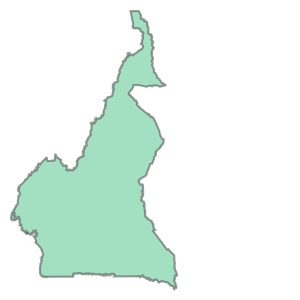

In [21]:
ADM = gpd.read_file(r'C:\Users\grace\GIS\povertyequity\urban_growth\CMN_boundaries.gdb', layer='CMR_ADM0_National')[['geometry']].to_crs("ESRI:102022")
ADM = cascaded_union(ADM.geometry)
ADM

In [17]:
test = points_to_coords(Settlements.geometry)

In [22]:
poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(test, ADM)

RuntimeError: generated polygon is not valid or is empty after intersection with the surrounding geometry `geom`

In [ ]:
test_buffered = gpd.clip(poly_shapes, BufferLayer)

In [19]:
# Settlements = LatestYearSett
# Settlements['geometry'] = Settlements['geometry'].apply(make_valid).buffer(0).apply(lambda x: shapely.wkt.loads(shapely.wkt.dumps(x, rounding_precision=4)))
# Settlements = gpd.GeoDataFrame.explode(Settlements, index_parts=False)
# print('Done. %s' % time.ctime())

Reducing chance of null or invalid geometries. Mon Nov  7 09:00:00 2022

Done. Mon Nov  7 09:00:05 2022


In [22]:
# Generate Voronoi diagram using buffer layer as our extent.
print('Drawing Thiessen (Voronoi) polygons using buffer as the bounding area. %s\n' % time.ctime())
LatestYearCatchments = voronoiDiagram4plg(Settlements, BufferLayer) # Demarcate the area around each feature which is closer to that feature than any other feature.
LatestYearCatchments.to_file(driver='GPKG', filename='Catchment.gpkg', layer=''.join(['Catchment_', str(StudyEnd)]))
print('Polygons drawn and written to file. %s' % time.ctime())

Drawing Thiessen (Voronoi) polygons using buffer as the bounding area. Mon Nov  7 09:00:27 2022



C:\Users\grace\miniconda3\envs\geo\lib\site-packages\longsgis\longsgis.py:32: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gs = gpd.GeoSeries([smp_vd]).explode()
C:\Users\grace\miniconda3\envs\geo\lib\site-packages\IPython\core\interactiveshell.py:3378: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


GEOSException: TopologyException: unable to assign free hole to a shell at -1507671.1451569756 346542.04978933523

In [20]:
Settlements['Sett_ID'].nunique()

14468

In [21]:
Settlements.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 14471 entries, 0 to 14467
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Sett_ID   14471 non-null  float64 
 1   year      14471 non-null  int64   
 2   ADM_ID    14471 non-null  int64   
 3   Area14    14365 non-null  float64 
 4   Area13    14222 non-null  float64 
 5   Area12    14089 non-null  float64 
 6   Area11    13960 non-null  float64 
 7   Area10    13856 non-null  float64 
 8   Area09    13744 non-null  float64 
 9   Area08    13674 non-null  float64 
 10  Area07    13567 non-null  float64 
 11  Area06    13474 non-null  float64 
 12  Area05    13382 non-null  float64 
 13  Area04    13299 non-null  float64 
 14  Area03    13234 non-null  float64 
 15  Area02    13156 non-null  float64 
 16  Area01    13072 non-null  float64 
 17  Area00    12975 non-null  float64 
 18  Area99    12813 non-null  float64 
 19  geometry  14471 non-null  geometry
dty

### 6. ADD NAMES ACCORDING TO LATEST YEAR CATCHMENTS
JOIN FEATURES: UCDB, Africapolis, and GeoNames onto the new settlement vectors.

##### Place names: Three options to work with. 

In [50]:
# Load, pull name field, rename, and reproject to match the catchments CRS.
UCDB = gpd.read_file('PlaceName/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg', layer=0)[['UC_NM_MN', 'geometry']].rename(columns={"UC_NM_MN": "UCDB_Name"}).to_crs("ESRI:102022")
Africapolis = gpd.read_file('PlaceName/AFRICAPOLIS2020.shp')[['agglosName', 'geometry']].rename(columns={"agglosName": "Afpl_Name"}).to_crs("ESRI:102022")
GeoNames = gpd.read_file('PlaceName/GeoNames.gpkg', layer=0)[['GeoName', 'geometry']].to_crs("ESRI:102022")
print(UCDB.info(), "\n\n\n", Africapolis.info(), "\n\n\n", GeoNames.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13135 entries, 0 to 13134
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   UCDB_Name  13135 non-null  object  
 1   geometry   13135 non-null  geometry
dtypes: geometry(1), object(1)
memory usage: 205.4+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7720 entries, 0 to 7719
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Afpl_Name  7720 non-null   object  
 1   geometry   7720 non-null   geometry
dtypes: geometry(1), object(1)
memory usage: 120.8+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 199390 entries, 0 to 199389
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   GeoName   199390 non-null  object  
 1   geometry  199390 non-null  geometry
dtypes: geometry(1), object(1)
memory usage: 3.0+ 

In [53]:
LatestYearCatchments = gpd.sjoin(LatestYearCatchments, GeoNames, how='left', predicate='contains', lsuffix="G3", rsuffix="GN") # Name file is point type, so we can do contain.
LatestYearCatchments = gpd.sjoin(LatestYearCatchments, Africapolis, how='left', predicate='intersects', lsuffix="G3", rsuffix="Af") # Name file is polygon type.
LatestYearCatchments = gpd.sjoin(LatestYearCatchments, UCDB, how='left', predicate='intersects', lsuffix="G3", rsuffix="UC") # Name file is polygon type.

In [54]:
print(LatestYearCatchments.info(), "\n\n", LatestYearCatchments.sample(10))

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 86897 entries, 0 to 86838
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ADM_ID     86897 non-null  int32   
 1   year       86897 non-null  int64   
 2   Sett_ID    86897 non-null  float64 
 3   geometry   86897 non-null  geometry
 4   index_GN   117 non-null    float64 
 5   GeoName    117 non-null    object  
 6   index_Af   13566 non-null  float64 
 7   Afpl_Name  13566 non-null  object  
 8   index_UC   3052 non-null   float64 
 9   UCDB_Name  3052 non-null   object  
dtypes: float64(4), geometry(1), int32(1), int64(1), object(3)
memory usage: 7.0+ MB
None 

        ADM_ID  year   Sett_ID  \
82120      78  2015    1605.0   
29947     148  2000   93736.0   
74968     179  2013   49810.0   
12179      79  1985  202546.0   
69119      72  2012    4346.0   
25591     137  1999   70818.0   
56776     241  2008  178146.0   
73929     125  2013   13563.0   
5

In [ ]:
print(LatestYearCatchments['GeoName'].count(), 
      LatestYearCatchments['Afpl_Name'].count(), 
      LatestYearCatchments['UCDB_Name'].count())

In [ ]:
LatestYearCatchments = LatestYearCatchments[['year', 'Sett_ID', 'GeoName', 'Afpl_Name', 'UCDB_Name', 'geometry']]

In [ ]:
# Create a single name column where non-named settlements are "UNK" but all others use one of the three name sources.
LatestYearCatchments['SettName'] = "UNK"

LatestYearCatchments.loc[
    LatestYearCatchments['Afpl_Name'].isnan == False, 
    'SettName'] = LatestYearCatchments['Afpl_Name']

LatestYearCatchments.loc[
    LatestYearCatchments['SettName'] == "UNK" & LatestYearCatchments['UCDB_Name'].isnan == False, 
    'SettName'] = LatestYearCatchments['UCDB_Name']

LatestYearCatchments.loc[
    LatestYearCatchments['SettName'] == "UNK" & LatestYearCatchments['GeoName'].isnan == False, 
    'SettName'] = LatestYearCatchments['GeoName']

LatestYearCatchments.sample(20)

In [ ]:
# Save intermediate file.
LatestYearCatchments.to_file(driver='GPKG', filename='Catchment.gpkg', layer=''.join(['Catchment_', str(StudyEnd)])

### 6. PREPARE YEARLY DATASETS
Population, nighttime lights, and any other annualized rasters

##### Population: Reproject to match WSFE.

In [6]:
CRS = gdal.WarpOptions(dstSRS='ESRI:102022')
PopFiles = os.listdir('Population/')

for item in PopFiles:
    InputFileName = os.path.join(ProjectFolder, "Population", item)
    InputRaster = gdal.Open(InputFileName)
    OutputFileName = "Wpop_" + str(re.sub(r'[^0-9]', '', item)) + "_albers.tif"
    OutputRaster = os.path.join(ProjectFolder, "Population", OutputFileName)
    if exists(OutputRaster):
        pass
    else:
        Warp = gdal.Warp(OutputRaster, 
                     InputRaster, 
                     format='GTiff', 
                     options=CRS) # Reproject to Africa Albers Equal Area Conic
        Warp = None # Closes the files

In [7]:
print(os.listdir('Population/'))

['cmr_ppp_2000_UNadj.tif', 'cmr_ppp_2001_UNadj.tif', 'cmr_ppp_2002_UNadj.tif', 'cmr_ppp_2003_UNadj.tif', 'cmr_ppp_2004_UNadj.tif', 'cmr_ppp_2005_UNadj.tif', 'cmr_ppp_2006_UNadj.tif', 'cmr_ppp_2007_UNadj.tif', 'cmr_ppp_2008_UNadj.tif', 'cmr_ppp_2009_UNadj.tif', 'cmr_ppp_2010_UNadj.tif', 'cmr_ppp_2011_UNadj.tif', 'cmr_ppp_2012_UNadj.tif', 'cmr_ppp_2013_UNadj.tif', 'cmr_ppp_2014_UNadj.tif', 'cmr_ppp_2015_UNadj.tif', 'Wpop_2000_albers.tif', 'Wpop_2001_albers.tif', 'Wpop_2002_albers.tif', 'Wpop_2003_albers.tif', 'Wpop_2004_albers.tif', 'Wpop_2005_albers.tif', 'Wpop_2006_albers.tif', 'Wpop_2007_albers.tif', 'Wpop_2008_albers.tif', 'Wpop_2009_albers.tif', 'Wpop_2010_albers.tif', 'Wpop_2011_albers.tif', 'Wpop_2012_albers.tif', 'Wpop_2013_albers.tif', 'Wpop_2014_albers.tif', 'Wpop_2015_albers.tif']


In [8]:
CheckContents = rasterio.open(os.path.join(ProjectFolder, "Population", os.listdir('Population/')[25]))
print(CheckContents)
print(dir(CheckContents))
print(CheckContents.crs)
print(CheckContents.dtypes)
print(CheckContents.nodatavals)
print(CheckContents.read(1).min(), CheckContents.read(1).mean(), np.median(CheckContents.read(1)), CheckContents.read(1).max())
del CheckContents

<open DatasetReader name='C:/Users/grace/GIS/povertyequity/urban_growth/Cameroon/Population/Wpop_2009_albers.tif' mode='r'>
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pyx_vtable__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_block_shapes', '_closed', '_count', '_crs', '_crs_wkt', '_descriptions', '_dtypes', '_env', '_gcps', '_get_crs', '_get_rpcs', '_handle_crswkt', '_has_band', '_has_gcps_or_rpcs', '_mask_flags', '_nodatavals', '_offsets', '_read', '_rpcs', '_scales', '_set_all_descriptions', '_set_all_offsets', '_set_all_scales', '_set_all_units', '_set_attrs_from_dataset_handle', '_set_crs', '_set_gcps', '_set_nodatavals', '_set_rpcs', '_transform', '_units', 'block_shapes', 'block_s

### Associating yearly datasets.

##### SETTLEMENT EXTENTS BY YEAR

Concatenate for cumulative year versions.

##### THIESSEN (VORONOI) POLYGONS

For each year, demarcate the surrounding space which is closest to a particular feature than to any other feature in the year set.

##### BUFFER

Buffer area of each built-up polygon and use that buffer to clip the Thiessen areas.

##### MASK

Use the buffered Thiessen polygons to reduce the raster size and limit the area included in the zonal stats.

##### ZONAL STATISTICS

Summarize raster data by the buffered Thiessen polygons.

#### Input datasets

In [ ]:
BuiltAreaList = fiona.listlayers("WSFE_CuDissolve.gpkg")
print(BuiltAreaList)

In [ ]:
PopRasterList = [rioxarray.open_rasterio(item, masked=True) 
                 for item in glob.glob(r'C:\Users\grace\GIS\povertyequity\urban_growth\TCD_WorldPop' 
                                       + '**/*.tif', recursive=True)] 

print(PopRasterList)

for item in PopRasterList:
    print(item.rio.crs) 

#### Settlement extents by year (cumulative built areas)

In [ ]:
CheckingContents = gpd.read_file("WSFE_CuDissolve.gpkg", layer=5)
CheckingContents.info() # We want our BuiltAllYears dataframe below to have the same fields as the pre-appended layers.
del CheckingContents

In [ ]:
BuiltAllYears = gpd.GeoDataFrame(
    columns=['GRID3_splitID', 'ADM', 'year', 'WSFE_ID', 'GRID3_OID', 'GeoName', 'Afpl_Name', 'UCDB_Name', 'geometry'], 
    geometry='geometry', crs = "ESRI:102022")
print(BuiltAllYears.info())
print(BuiltAllYears.crs)
print(BuiltAllYears.head())

In [ ]:
for item in BuiltAreaList:
    CuYear = re.sub(r'[^0-9]', '', item)
    TempItem = gpd.read_file("WSFE_CuDissolve.gpkg", layer=item)
    TempItem["CuYear"] = CuYear
    BuiltAllYears = pd.concat([BuiltAllYears, TempItem])

BuiltAllYears.to_file(driver="GPKG", filename="WSFE_Cumulative_TCD.gpkg", layer="WSFE_AllYears")
BuiltAllYears.sample(20)

In [ ]:
print(BuiltAllYears.crs)

---

### Previous steps (ArcGIS Pro and Python)

##### DATA PREP 

Projection for all datasets --> Africa Albers Equal Area Conic 

Remove unnecessary fields (e.g. extra fields in gazetteer data) 

##### WSFE AND ADM3 

RASTER MATH: "Join" ADM ID onto WSFE by creating unique string. 

VECTOR MATH: Split unique ID from raster math into separate columns, and remove non-buildup years (0000). 

##### GRID3 AND ADM3 

RASTER MATH: "Join" ADM3 ID onto GRID3 by creating unique string. 

VECTOR MATH: Split unique ID from raster math into separate columns. 

##### ADD NAMES 

Join features: UCDB, Africapolis, and GeoNames

##### WSFE AND GRID3 

NEAR JOIN: Join GRID3 ID onto WSFE by spatial (within a distance) and attribute matching. 
 
##### WSFE CUMULATIVE 

DISSOLVE BY YEAR SETS: Create separate feature layers of each cumulative year. 

---

### Associating yearly datasets. (current notebook)

#### Prepare workspace

In [ ]:
# Installs

#import sys
#!{sys.executable} -m pip install voronoi-diagram-for-polygons xarray-spatial rioxarray pygeos

In [ ]:
# import sys
# !{sys.executable} -m pip install --user --upgrade pygeos

In [ ]:
# !{sys.executable} -m pip install --user ogr

#### Input datasets

In [ ]:
BuiltAreaList = fiona.listlayers("WSFE_cumulativelayers.gdb")
print(BuiltAreaList)

In [ ]:
Boundary = gpd.read_file('WSFE.gdb', layer=1)#; Boundary.crs = "ESRI:102022"
print(Boundary.info())
print(Boundary.crs)

In [ ]:
PopRasterList = [rioxarray.open_rasterio(item, masked=True) 
                 for item in glob.glob(r'C:\Users\wb527163\GEO_Cdrive_Grace\urban_growth\WorldPop_tifs_albers' 
                                       + '**/*.tif', recursive=True)] 

print(PopRasterList)

for item in PopRasterList:
    print(item.rio.crs) 

#### Settlement extents by year (cumulative built areas)

In [ ]:
BuiltAllYears = gpd.GeoDataFrame(
    columns=['GRID3_splitID', 'MAX_year', 'Shape_Length', 'Shape_Area', 'CuYear', 'geometry'], 
    geometry='geometry', crs = "ESRI:102022")
print(BuiltAllYears.info())
print(BuiltAllYears.crs)
print(BuiltAllYears.head())

In [ ]:
for item in BuiltAreaList:
    CuYear = re.sub(r'[^0-9]', '', item)
    TempItem = gpd.read_file("WSFE_cumulativelayers.gdb", layer=item)
    TempItem["CuYear"] = CuYear
    BuiltAllYears = pd.concat([BuiltAllYears, TempItem])
    
BuiltAllYears.sample(20)

In [ ]:
print(BuiltAllYears.crs)

#### Thiessen polygons (Voronoi polygons): For each year, demarcate the surrounding space which is closest to a particular feature than to any other feature in the year set.
#### Then, buffer area of each built-up polygon and use that buffer to clip the Thiessen areas.

In [ ]:
#If CRSs do not match:
#PopRasterList = [item.rio.reproject_match(BuiltArea) for item in PopRasterList]
#Boundary = Boundary.to_crs(BuiltArea.crs)

In [ ]:
Boundary = Boundary.dissolve()
Boundary.info()

In [ ]:
# BuiltThiessenBuffer = gpd.GeoDataFrame(
#     columns=['GRID3_splitID', 'MAX_year', 'Shape_Length', 'Shape_Area', 'CuYear', 'geometry'], 
#     geometry='geometry', crs = "ESRI:102022")

In [ ]:
for item in BuiltAreaList:
    print('Loading layer %s. %s\n' % (item, time.ctime()))
    CuYear = re.sub(r'[^0-9]', '', item) # Pull the year of feature layer (e.g. "2005") from the numeric portion of the layer name.
    Layer = gpd.read_file("WSFE_cumulativelayers.gdb", layer=item) # Read in the layer as a geodataframe.
    print('Create a buffer around the features in the original layer. %s\n' % time.ctime())
    BufferLayer = Layer
    BufferLayer['geometry'] = BufferLayer['geometry'].apply(make_valid) # This is a workaround for any null geometries.
    BufferLayer['geometry'] = BufferLayer['geometry'].buffer(2000) # Create a 2km buffer around the original feature.
    BufferLayer.to_file(driver='ESRI Shapefile', filename=''.join(['Buff_', CuYear, '.shp']))
    print('Buffered version finished and saved to file. %s\n' % time.ctime())
    del CuYear, Layer, BufferLayer

In [ ]:
for item in ['cu_sel_2011', 'cu_sel_2012', 'cu_sel_2013', 'cu_sel_2014', 'cu_sel_2015']:
# Error happened in cu_sel_2010. See OneNote page for details.
# ValueError: No Shapely geometry can be created from null value
# for item in BuiltAreaList:
    print('Loading layer %s. %s\n' % (item, time.ctime()))
    CuYear = re.sub(r'[^0-9]', '', item) # Pull the year of feature layer (e.g. "2005") from the numeric portion of the layer name.
    Layer = gpd.read_file("WSFE_cumulativelayers.gdb", layer=item) # Read in the layer as a geodataframe.
    Buffer = gpd.read_file(filename=''.join(['Buff_', CuYear, '.shp']))
    print('Loaded. Assigning year field. %s\n' % time.ctime())
    Layer["CuYear"] = CuYear # Give geodataframe a field where every value is the year of cumulative buildup represented by the layer. This will be useful if concatenating all the layers together into a single dataset.
    print('Assigned. Drawing Thiessen (Voronoi) polygons using buffer as the bounding area. %s\n' % time.ctime())
    ThiessenLayer = voronoiDiagram4plg(Layer, Buffer) # Demarcate the area around each feature which is closer to that feature than any other feature.
    ThiessenLayer.to_file(driver='ESRI Shapefile', filename=''.join(['ThBuf_', CuYear, '.shp']))
    print('Polygons drawn and written to file. %s\n' % time.ctime())
    del CuYear, Layer, ThiessenLayer

In [ ]:
# This was the only year that gave me trouble. Running it outside of the list now that the issues are resolved.
item = 'cu_sel_2010'
print('Loading layer %s. %s\n' % (item, time.ctime()))
CuYear = re.sub(r'[^0-9]', '', item) # Pull the year of feature layer (e.g. "2005") from the numeric portion of the layer name.
Layer = gpd.read_file("WSFE_cumulativelayers.gdb", layer=item) # Read in the layer as a geodataframe.
Buffer = gpd.read_file(filename=''.join(['Buff_', CuYear, '.shp']))
print('Loaded. Assigning year field. %s\n' % time.ctime())
Layer["CuYear"] = CuYear # Give geodataframe a field where every value is the year of cumulative buildup represented by the layer. This will be useful if concatenating all the layers together into a single dataset.
print('Assigned. Drawing Thiessen (Voronoi) polygons. %s\n' % time.ctime())
Layer['geometry'] = Layer['geometry'].apply(make_valid).buffer(0.1).simplify(10) # Using several workarounds for any null geometries. Our inputs don't need a high level of precision.
Buffer['geometry'] = Buffer['geometry'].apply(make_valid)
ThiessenLayer = voronoiDiagram4plg(Layer, Buffer) # Demarcate the area around each feature which is closer to that feature than any other feature.
ThiessenLayer.to_file(driver='ESRI Shapefile', filename=''.join(['ThBuf_', CuYear, '.shp']))
print('Polygons drawn and written to file. %s\n' % time.ctime())

In [ ]:
BuiltListless2010 = BuiltAreaList.remove('cu_sel_2010')
BuiltAreaList

In [ ]:
print('Thiessen polygons did not retain feature attributes. Need to join back on spatially. \n\n')
for item in BuiltAreaList:
    print('Year: %s %s\n' % (item, time.ctime()))
    CuYear = re.sub(r'[^0-9]', '', str(item))
    ThiessenLayer = gpd.read_file(filename=''.join(['ThBuf_', CuYear, '.shp']))
    Layer = gpd.read_file("WSFE_cumulativelayers.gdb", layer=item)
    print('Loaded original features and Thiessen layers. Joining together. %s\n' % time.ctime())
    ThiessenLayer = gpd.sjoin(ThiessenLayer, Layer, how='left', predicate='contains')
    print('Finished! Writing to file. %s\n' % time.ctime())
    ThiessenLayer.to_file(driver='ESRI Shapefile', filename=''.join(['ThB2_', CuYear, '.shp']))
    del CuYear, ThiessenLayer, Layer
print('All years finished (except 2010).')

In [ ]:
# for item in BuiltAreaList:
#     print('Loading Thiessen areas and buffered polygons from layer %s. %s\n' % (item, time.ctime()))
#     CuYear = re.sub(r'[^0-9]', '', item) # Pull the year of feature layer (e.g. "2005") from the numeric portion of the layer name.
#     ThiessenLayer = gpd.read_file(filename=''.join(['Thies_', CuYear, '.shp'])) # Read in the layer as a geodataframe.
#     BufferLayer = gpd.read_file(filename=''.join(['Buff_', CuYear, '.shp']))
#     print('Now clipping the Thiessen polygons with the buffer. %s\n' % time.ctime())
#     ThiessenBufferLayer = gpd.clip(ThiessenLayer, BufferLayer) # Clip the demarcated area so that coverage ends at the 2km mark. This will be both the mask used to reduce the file size of the population rasters, and the zones used to summarize the pop data during zonal statistics.
#     print('Clipped. Polygons did not retain feature attributes. Joining back on. %s\n' % time.ctime())
#     ThiessenBufferLayer = ThiessenBufferLayer.merge(Layer, how='left', left_index=True, right_index=True) # Voronoi function does not retain the attributes (leaves them all Null for whatever reason). Just joining it all back together.
#     print('Finished! Writing to file. %s\n' % time.ctime())
#     ThiessenBufferLayer.to_file(driver='ESRI Shapefile', filename=''.join(['ThBuf_', CuYear, '.shp']))
#     print(ThiessenBufferLayer.sample(5))
#     print('\nNext layer. %s\n' % time.ctime())
#     del CuYear, ThiessenLayer, BufferLayer, ThiessenBufferLayer

#### Zonal statistics
https://gis.stackexchange.com/questions/77993/issue-trying-to-create-zonal-statistics-using-gdal-and-python

In [ ]:
def zonal_stats(feat, input_zone_polygon, input_value_raster, statistic='sum'):

    # Open data
    raster = gdal.Open(input_value_raster)
    shp = ogr.Open(input_zone_polygon)
    lyr = shp.GetLayer()

    # Get raster georeference info
    transform = raster.GetGeoTransform()
    xOrigin = transform[0]
    yOrigin = transform[3]
    pixelWidth = transform[1]
    pixelHeight = transform[5]

    # Get extent of feat
    geom = feat.GetGeometryRef()
    if (geom.GetGeometryName() == 'MULTIPOLYGON'):
        count = 0
        pointsX = []; pointsY = []
        for polygon in geom:
            geomInner = geom.GetGeometryRef(count)    
            ring = geomInner.GetGeometryRef(0)
            numpoints = ring.GetPointCount()
            for p in range(numpoints):
                    lon, lat, z = ring.GetPoint(p)
                    pointsX.append(lon)
                    pointsY.append(lat)    
            count += 1
    elif (geom.GetGeometryName() == 'POLYGON'):
        ring = geom.GetGeometryRef(0)
        numpoints = ring.GetPointCount()
        pointsX = []; pointsY = []
        for p in range(numpoints):
                lon, lat, z = ring.GetPoint(p)
                pointsX.append(lon)
                pointsY.append(lat)

    else:
        sys.exit()

    xmin = min(pointsX)
    xmax = max(pointsX)
    ymin = min(pointsY)
    ymax = max(pointsY)

    # Specify offset and rows and columns to read
    xoff = int((xmin - xOrigin)/pixelWidth)
    yoff = int((yOrigin - ymax)/pixelWidth)
    xcount = int((xmax - xmin)/pixelWidth)+1
    ycount = int((ymax - ymin)/pixelWidth)+1

    # Create memory target raster
    target_ds = gdal.GetDriverByName('MEM').Create('', xcount, ycount, gdal.GDT_Byte)
    target_ds.SetGeoTransform((
        xmin, pixelWidth, 0,
        ymax, 0, pixelHeight,
    ))

    # Create for target raster the same projection as for the value raster
    raster_srs = osr.SpatialReference()
    raster_srs.ImportFromWkt(raster.GetProjectionRef())
    target_ds.SetProjection(raster_srs.ExportToWkt())

    # Rasterize zone polygon to raster
    gdal.RasterizeLayer(target_ds, [1], lyr, burn_values=[1])

    # Read raster as arrays
    banddataraster = raster.GetRasterBand(1)
    dataraster = banddataraster.ReadAsArray(xoff, yoff, xcount, ycount).astype(numpy.float)

    bandmask = target_ds.GetRasterBand(1)
    datamask = bandmask.ReadAsArray(0, 0, xcount, ycount).astype(numpy.float)

    # Mask zone of raster
    zoneraster = numpy.ma.masked_array(dataraster,  numpy.logical_not(datamask))

    # Calculate statistics of zonal raster
    if (statistic == 'sum'):
        return numpy.sum(zoneraster)
    elif (statistic == 'mean'):
        return numpy.mean(zoneraster)
    elif (statistic == 'count'):
        return numpy.ma.count(zoneraster)
    elif (statistic == 'median'):
        return numpy.median(zoneraster)
    elif (statistic == 'min'):
        return numpy.min(zoneraster)
    elif (statistic == 'max'):
        return numpy.max(zoneraster)
    elif (statistic == 'std'):
        return numpy.std(zoneraster)
    else:
        return numpy.sum(zoneraster)
    
    
def loop_zonal_stats(input_zone_polygon, input_value_raster, statistic):
#         Parameters
#         ----------
#         input_zone_polygon: string
#             File path to read from using ogr.Open().
#         input_value_raster : string, default None
#             The OGR format driver used to write the vector file.
#             If not specified, it attempts to infer it from the file extension.
#             If no extension is specified, it saves ESRI Shapefile to a folder.
#         statistic : string, default = 'sum'
#             The statistic used to aggregate values in the input raster. 
#             Output will be a single value associated with the input zone.
#             Options: 'sum', 'mean', 'count', 'median', 'min', 'max', 'std'

    shp = ogr.Open(input_zone_polygon)
    lyr = shp.GetLayer()
    featList = range(lyr.GetFeatureCount())
    statDict = {}

    for FID in featList:
        feat = lyr.GetFeature(FID)
        statValue = zonal_stats(feat, input_zone_polygon, input_value_raster, statistic)
        statDict[FID] = statValue
    return statDict

In [ ]:
PopRasterList = glob.glob(r'WorldPop_tifs_albers/*.tif') # List all files in the WorldPop folder that have a .tif extension
StatType = 'sum'

print('Running zonal statistics. \n')
for item in PopRasterList:
    Year = re.sub(r'[^0-9]', '', str(item)) # Get year of raster dataset. This will be used to choose the right polygon zones.
    print('Year: %s %s' % (Year, time.ctime()))
    RasterLayer = item
    ZoneLayerName = ''.join(['ThB2_', Year, '.shp'])
    ColumnName = ''.join(['Pop', Year]) # Zonal stats outputs will be named after the year and dataset, as a column in the settlements polygon.
    print('Zonal statistics (%s) for year %s. %s' % (StatType, Year, time.ctime()))
    zStats = loop_zonal_stats(ZoneLayerName, RasterLayer, StatType)
    print('Stats finished for year %s! Joining back onto Thiessen polygons. %s' % (Year, time.ctime()))
    zStats = pd.DataFrame.from_dict(zStats, orient = 'index', columns = [ColumnName])
    ZoneLayer = gpd.read_file(ZoneLayerName)
    ZoneWithStats = ZoneLayer.merge(zStats, how='left', left_index=True, right_index=True)
    print('And now joining the Thiessen polygon attributes back onto the settlements via spatial join. %s' % time.ctime())
    SettlementLayer = gpd.read_file("WSFE_cumulativelayers.gdb", layer=''.join(['cu_sel_', Year]))
    SettlementLayer = gpd.sjoin(SettlementLayer, ZoneWithStats, how='left', predicate='within')
    print('Joined. Writing the settlements to file with zonal info in attributes. %s\n' % time.ctime())
    SettlementLayer.to_file(''.join([StatType, '_', Year]))
    del Year, RasterLayer, ZoneLayer, ColumnName, zStats, ZoneWithStats, SettlementLayer
print('All years finished (except 2010). Outputs stored as shapefiles in project workspace.')

### Scratch and notes

In [ ]:
# Raster dataset
input_value_raster = r'WorldPop_tifs_albers/cmr_ppp_2000_UNadj.tif'
# Vector dataset(zones)
input_zone_polygon = 'ThB2_2000.shp'

Year2000 = loop_zonal_stats(input_zone_polygon, input_value_raster, statistic='sum')
Year2000

In [ ]:
poly = gpd.read_file('ThB2_2000.shp')
zstats = pd.DataFrame.from_dict(Year2000, orient = 'index', columns = ['Pop2000'])
poly = poly.merge(zstats, how='left', left_index=True, right_index=True)
poly.to_file(driver='ESRI Shapefile', filename='test2000_zonal.shp')

##### EARLIER VERSION CODE BLOCKS

In [ ]:
daShapefile = r'ThB2_2000.shp'
driver = ogr.GetDriverByName('ESRI Shapefile')
dataSource = driver.Open(daShapefile, 0) # 0 means read-only. 1 means writeable.

# Check to see if shapefile is found.
if dataSource is None:
    print('Could not open %s' % (daShapefile))
else:
    print('Opened %s' % (daShapefile))
    layer = dataSource.GetLayer()
    featureCount = layer.GetFeatureCount()
    print("Number of features in %s: %d" % (os.path.basename(daShapefile),featureCount))

##### VALIDATION

In [ ]:
layer2010 = gpd.read_file("WSFE_cumulativelayers.gdb", layer='cu_sel_2010')

ext_vertices = []
int_vertices = []

for i, row in layer2010.iterrows():
    # It's better to check if multigeometry
    multi = row.geometry.type.startswith("Multi")

    if multi:
        n = 0
        allparts = []
        # iterate over all parts of multigeometry
        for part in row.geometry:
            part_length = len(part.exterior.coords)
            allparts.append(part_length)
            n += min(allparts)
    else:
        n = len(row.geometry.exterior.coords)
    ext_vertices.append(n) ###


layer2010["ext_vertices"] = ext_vertices
print(layer2010.sample(10))

invalid2010 = layer2010[layer2010['ext_vertices']<4]
print(invalid2010)

In [ ]:
layer2011 = gpd.read_file("WSFE_cumulativelayers.gdb", layer='cu_sel_2011')

ext_vertices = []
int_vertices = []

for i, row in layer2011.iterrows():
    # It's better to check if multigeometry
    multi = row.geometry.type.startswith("Multi")

    if multi:
        n = 0
        allparts = []
        # iterate over all parts of multigeometry
        for part in row.geometry:
            part_length = len(part.exterior.coords)
            allparts.append(part_length)
            n += min(allparts)
    else:
        n = len(row.geometry.exterior.coords)
    ext_vertices.append(n) ###


layer2011["ext_vertices"] = ext_vertices
print(layer2011.sample(10))

invalid2011 = layer2011[layer2011['ext_vertices']<4]
print(invalid2011)

In [ ]:
print(min(layer2010['ext_vertices']))
print(min(layer2011['ext_vertices']))
print(layer2010['ext_vertices'].isna().sum())
print(layer2011['ext_vertices'].isna().sum())

In [ ]:
non_multi = []

for i, row in layer2010.iterrows():
    multi = row.geometry.type.startswith("Multi")
    
    if multi:
        pass
    else:
        n = row
    non_multi.append(n) ###
print(len(non_multi))

In [ ]:
ext_vertices = []
int_vertices = []

for i, row in layer2010.iterrows():
    # It's better to check if multigeometry
    try:
        n = len(row.geometry.interior.coords)
    except:
        pass
    int_vertices.append(n) ###

layer2010["int_vertices"] = int_vertices
print(layer2010.sample(10))

invalid2010 = layer2010[layer2010['int_vertices']<4]
print(invalid2010)